## Imports and Configurations

In [163]:
import os.path
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import random
import scipy.misc
import time
import shutil
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Input, Lambda
from keras.layers.core import Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU

from sklearn.utils import shuffle

%matplotlib inline

In [164]:
# Configurations here

flags = {
    'augment_data': False,
    'train_model': True,
    'show_plots': True,
    'show_images': False,
    'downsample_straight': True,
    'distribution': 'uniform',
    'model': 'nvidia',
    'straight_keep_num': 500,
    'augment_count': 15000,
    'dropout': 0.25
}

## Load and Preprocess Data

#### Data Augmentation and Balancing

In [165]:
def augment_brightness(image):
    # Randomly select a percentage change
    random_bright = 0.25 + np.random.uniform()
    
    # Change to HSV to change the brightness V
    image_augmented = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image_augmented[:,:,2] = image_augmented[:,:,2]*random_bright
    
    # Convert back to RGB
    image_augmented = cv2.cvtColor(image_augmented,cv2.COLOR_HSV2RGB)
    return image_augmented

def mirror_image(image, angle):
    image_mirrored = cv2.flip(image,1)
    angle = -angle
    return image_mirrored, angle

def perturb_angle(angle):
    new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
    return new_angle

def augment_image(image, angle):
    mirror = bool(random.randint(0,1))
    perturb = bool(random.randint(0,1))
    brighten = bool(random.randint(0,1))
    
    if mirror:
        image, angle = mirror_image(image, angle)
    if perturb:
        angle = perturb_angle(angle)
    if brighten:
        image = augment_brightness(image)
        
    return image, angle

def create_save_augmented_images(count, distribution='normal'):
    df = pd.read_csv('data/udacity_data/driving_log.csv')
    df_aug = pd.DataFrame(columns=df.columns, index=df.index)
    
    binned =  np.digitize(df['steering'].values, np.arange(-1, 1, 0.1))
    binned_indexes = []
    for i in range(21):
        binned_indexes.append([j for j,v in enumerate(binned) if v == i])
    valid_bins = [i for i,v in enumerate(binned_indexes) if len(v) > 0]
    valid_bins.remove(11) # no straights
    
    
    for j in range(count):
        while True:
            if distribution == 'uniform':
                bin = np.random.choice(valid_bins)
                index = np.random.choice(binned_indexes[bin])
            elif distribution == 'normal':
                index = np.random.choice(len(df))
            elif distribution == 'fat_tail':
                switch = bool(random.randint(0,1))
                if switch:
                    bin = np.random.choice(valid_bins)
                    index = np.random.choice(binned_indexes[bin])
                else:
                    index = np.random.choice(len(df))
            if df.loc[index]['steering'] != 0:
                break
            
        path = 'data/udacity_data/' + df.loc[index]['center']
        image = mpimg.imread(path)
        angle = df.iloc[index]['steering']
        
        image, angle = augment_image(image, angle)
        
        df_aug.loc[j] = df.iloc[index].values
        df_aug.set_value(j, 'steering', angle)
        filename = 'IMG/augmented_{0}.jpg'.format(j)
        filepath = 'data/augmented_data/' + filename
        df_aug.set_value(j, 'center', filename)
        scipy.misc.imsave(filepath, image)
        if j % 1000 == 0:
            print('{} images complete'.format(j))
    
    df_aug.dropna().to_csv('data/augmented_data/driving_log.csv', index=False)

In [166]:
if flags['augment_data']:
    start = time.time()
    create_save_augmented_images(flags['augment_count'], flags['distribution'])
    end = time.time()
    print("Execution Time (secs):", end - start)

#### Load Data

In [167]:
df_udacity = pd.read_csv('data/udacity_data/driving_log.csv')
df_mirror = pd.read_csv('data/mirrored_data/driving_log.csv')
df_aug = pd.read_csv('data/augmented_data/driving_log.csv')
df_mine = pd.read_csv('data/my_driving_data/driving_log.csv')
df = pd.concat((df_udacity, df_aug, df_mine))
df.reset_index(drop=True, inplace=True)
df.tail()

,center,left,right,steering,throttle,brake,speed
25739,IMG/center_2017_02_02_16_55_28_644.jpg,IMG/left_2017_02_02_16_55_28_644.jpg,IMG/right_2017_02_02_16_55_28_644.jpg,0.0,0.0,0.0,4.196266
25740,IMG/center_2017_02_02_16_55_28_747.jpg,IMG/left_2017_02_02_16_55_28_747.jpg,IMG/right_2017_02_02_16_55_28_747.jpg,0.0,0.0,0.0,4.152821
25741,IMG/center_2017_02_02_16_55_28_850.jpg,IMG/left_2017_02_02_16_55_28_850.jpg,IMG/right_2017_02_02_16_55_28_850.jpg,0.0,0.0,0.0,4.109815
25742,IMG/center_2017_02_02_16_55_28_954.jpg,IMG/left_2017_02_02_16_55_28_954.jpg,IMG/right_2017_02_02_16_55_28_954.jpg,0.0,0.0,0.0,4.067245
25743,IMG/center_2017_02_02_16_55_29_062.jpg,IMG/left_2017_02_02_16_55_29_062.jpg,IMG/right_2017_02_02_16_55_29_062.jpg,0.0,0.0,0.0,4.016730


In [168]:
if flags['downsample_straight']:
    straight_indexes = df[df.steering == 0].index
    drop_indexes = np.random.choice(straight_indexes, len(straight_indexes) - flags['straight_keep_num'] , replace=False)
    df.drop(drop_indexes, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(df.tail())

                                       center  \
19658  IMG/center_2017_02_02_16_55_24_344.jpg   
19659  IMG/center_2017_02_02_16_55_24_470.jpg   
19660  IMG/center_2017_02_02_16_55_25_441.jpg   
19661  IMG/center_2017_02_02_16_55_26_807.jpg   
19662  IMG/center_2017_02_02_16_55_27_820.jpg   

                                        left  \
19658   IMG/left_2017_02_02_16_55_24_344.jpg   
19659   IMG/left_2017_02_02_16_55_24_470.jpg   
19660   IMG/left_2017_02_02_16_55_25_441.jpg   
19661   IMG/left_2017_02_02_16_55_26_807.jpg   
19662   IMG/left_2017_02_02_16_55_27_820.jpg   

                                        right  steering  throttle     brake  \
19658   IMG/right_2017_02_02_16_55_24_344.jpg  0.343383       1.0  0.000000   
19659   IMG/right_2017_02_02_16_55_24_470.jpg  0.000000       1.0  0.000000   
19660   IMG/right_2017_02_02_16_55_25_441.jpg -0.366753       1.0  0.000000   
19661   IMG/right_2017_02_02_16_55_26_807.jpg  0.000000       0.0  1.000000   
19662   IMG/right_201

In [169]:
# Split and shuffle data
num_examples = df['center'].count()
indexes = np.arange(0, num_examples)
# np.random.shuffle(indexes)
train_indexes, val_indexes = train_test_split(indexes, test_size=0.2)
df_train = df.loc[train_indexes]
df_val = df.loc[val_indexes]

#### Plots

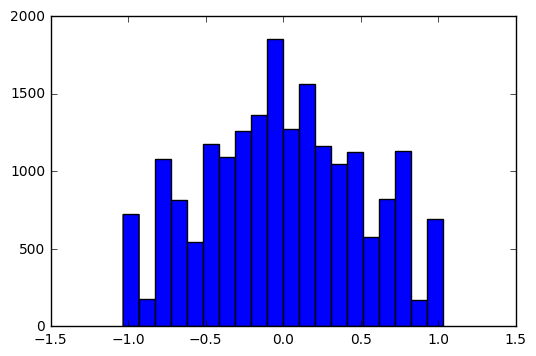

In [170]:
if flags['show_plots']:    
    plt.hist(df['steering'], bins=20)

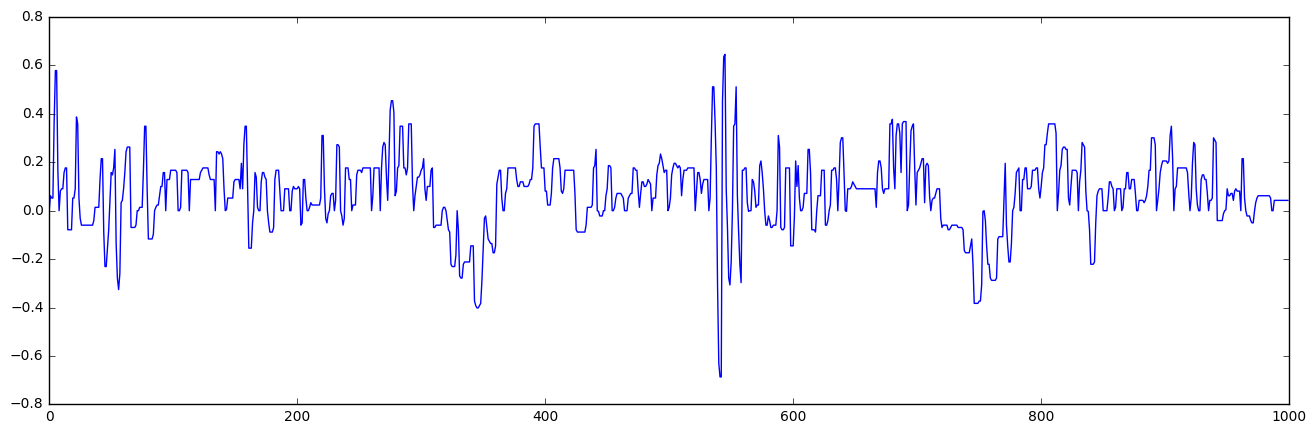

In [171]:
if flags['show_plots']:
    plt.figure(figsize=(16,5))
    plt.plot(df['steering'].values[0:1000])

In [172]:
if flags['show_images']:
    for i in range(3):
        index = np.random.choice(df_udacity.index)
        filename = 'data/udacity_data/' + df_udacity['center'][index]
        image = mpimg.imread(filename)
        plt.figure()
        plt.imshow(image)

## Setup and Train Network

#### Data Generator

In [173]:
def train_generator(df):
    while True:
        batch_indexes = np.random.choice(df.index, 128, replace=False)
        batch = df.loc[batch_indexes]
        images = []
        for index, row in batch.iterrows():
            filename = row['center']
            if 'augmented' in filename:
                path = 'data/augmented_data/' + filename
            elif 'mirrored' in filename:
                path = 'data/mirrored_data/' + filename
            elif '2017_02_02' in filename:
                path = 'data/my_driving_data/' + filename
            else:
                path = 'data/udacity_data/' + filename
            image = mpimg.imread(path)
            image = cv2.resize(image, (200, 66))
            image = image[np.newaxis, ...]
            images.append(image)
        batch_x = np.concatenate(images, axis=0)
        batch_y = batch['steering'].values
        yield batch_x, batch_y

#### Model and Training

In [174]:
if flags['model'] == 'alexnet':
    model = Sequential()
    
    # Normalize
    model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=(227, 227, 3)))
    
    # Output = 55 x 55
    model.add(Convolution2D(48, 11, 11, subsample=(4,4)))
    model.add(Activation('relu'))
    
    # Output = 27 x 27
    model.add(MaxPooling2D((3,3), strides=(2,2)))
    model.add(Convolution2D(128, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    
    # Output = 13 x 13
    model.add(MaxPooling2D((3,3), strides=(2,2)))
    model.add(Convolution2D(192, 3, 3, border_mode='same'))
    model.add(Activation('relu'))

    # Output = 13 x 13
    model.add(Convolution2D(192, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    
    # Output = 13 x 13
    model.add(Convolution2D(128, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    
    # Output = 4 x 4 x 128
    model.add(MaxPooling2D((3,3)))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(128))
    model.add(Dense(32))
    model.add(Dense(1))

In [175]:
if flags['model'] == 'nvidia':
    model = Sequential()

    model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=(66, 200, 3)))
    
    model.add(Convolution2D(24, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(36, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(48, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(Dropout(flags['dropout']))

    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Activation('relu'))
    model.add(Dropout(flags['dropout']))

    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(flags['dropout']))

    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(flags['dropout']))

    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(flags['dropout']))

    model.add(Dense(1))

In [176]:
if flags['train_model']:
    start = time.time()
    adam = Adam(lr=0.0003)
    model.compile(loss='mse', optimizer=adam)
    model.fit_generator(train_generator(df_train), samples_per_epoch=16000, 
                        nb_epoch=5, validation_data=train_generator(df_val), nb_val_samples=3968)
    model.save('model.h5')
    end = time.time()
    print("Training Time (s)", end - start)

Epoch 1/5
16000/16000 [==============================] - 35s - loss: 0.1560 - val_loss: 0.0605
Epoch 2/5
16000/16000 [==============================] - 33s - loss: 0.0770 - val_loss: 0.0430
Epoch 3/5
16000/16000 [==============================] - 32s - loss: 0.0608 - val_loss: 0.0258
Epoch 4/5
16000/16000 [==============================] - 32s - loss: 0.0522 - val_loss: 0.0248
Epoch 5/5
16000/16000 [==============================] - 32s - loss: 0.0468 - val_loss: 0.0228
Training Time (s) 169.59712100028992
